# TCC Facens

### Nomes dos integrantes:

* Ricardo da Silva
* Osmar Prado Jr.

Tema:

* Face Anti-Spoofing com modelos de deep learning

### Orientador:
* Johannes

Usar base-line o projeto keras:

### Base de dados
Para este estudo foi utilizado 32.000 imagens com faces já pré processadas (Crop) da base de dados CelebA-Spoof Dataset.
* 25.000 Treino 
 * 12.581 live
  * 12.419 spoof
* 7.000 teste 
 * 3.500 live
  * 3.500 spoof

### Donload CelebA_Spoof_32k.zip
* https://drive.google.com/file/d/1ZocQKFCabv4xbzDutmsa0wlkJQV6_DqT/view?usp=sharing


### Referencia CelebA-Spoof Dataset 
* https://github.com/Davidzhangyuanhan/CelebA-Spoof
* https://paperswithcode.com/dataset/celeba-spoof

*O conjunto de dados CelebA-Spoof está disponível apenas para fins de pesquisa não comercial.*
```
@inproceedings{CelebA-Spoof,
  title={CelebA-Spoof: Large-Scale Face Anti-Spoofing Dataset with Rich Annotations},
  author={Zhang, Yuanhan and Yin, Zhenfei and Li, Yidong and Yin, Guojun and Yan, Junjie and Shao, Jing and Liu, Ziwei},
  booktitle={European Conference on Computer Vision (ECCV)},
  year={2020}
}
```

link download:
* https://drive.google.com/file/d/1ZocQKFCabv4xbzDutmsa0wlkJQV6_DqT/view?usp=sharing



### Uso de GPU
Utilizamos o recursos do Google colab com ambiente com GPU habilitado

In [1]:
!nvidia-smi

Mon Apr 19 20:25:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.30       Driver Version: 457.30       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:01:00.0  On |                  N/A |
|  4%   45C    P8     9W / 120W |    690MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd

import cv2
import os

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K

from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


# gráfico
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
print('Tensorflow version: ', tf.version.VERSION)
print('Keras version: ', tf.keras.__version__)

Tensorflow version:  2.1.0
Keras version:  2.2.4-tf


### Iniciando Variaveis (Hiperparametro)

In [4]:
LOCAL_ROOT  = 'D:/CelebA_Spoof_32k'
PATH_TRAIN = LOCAL_ROOT +  '/train'
PATH_TEST = LOCAL_ROOT +  '/test'

INIT_LR = 1e-4
ALPHA = 1e-5
BATCH_SIZE = 32
IMG_SHAPE = (224, 224, 3)
EPOCHS = 50
SAMPLE_QTD = 1.0
RANDOM_STATE = 42

### Descompaquitando arquivos no colab
Podemos montar uma instancia do Google drive e desconpactar os arquivos na pasta local

In [5]:
#!unzip '/content/drive/MyDrive/Facens/TCC/CelebA_Spoof_32k.zip' -d './'

### Iniciando Variaveis

In [6]:
live = PATH_TRAIN + '/live/'
spoof = PATH_TRAIN + '/spoof/'

live_path = os.listdir(live)
spoof_path = os.listdir(spoof)

### Visualizando as imagens

In [7]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

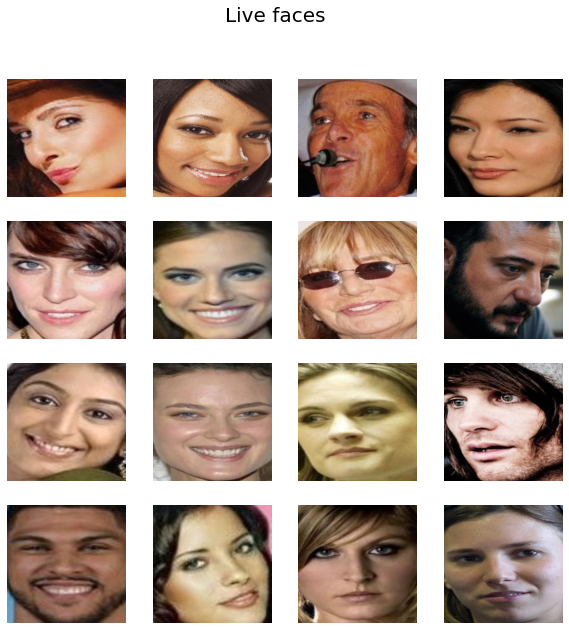

In [8]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(live + live_path[i]), cmap='gray')
    plt.suptitle("Live faces",fontsize=20)
    plt.axis('off')

plt.show()

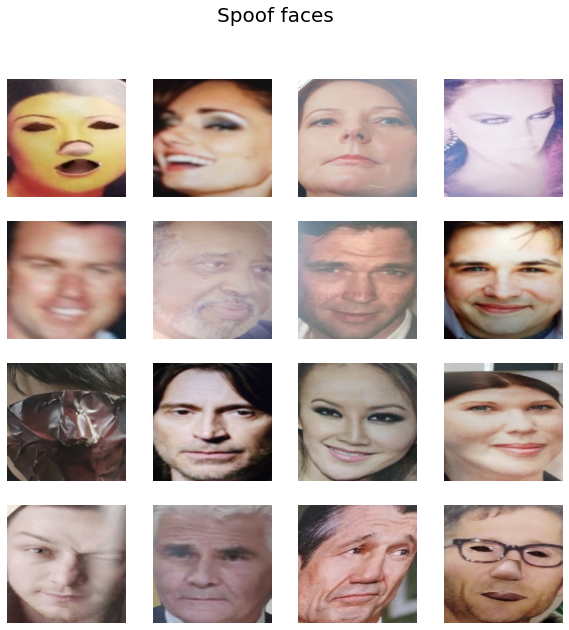

In [9]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(spoof + spoof_path[i]), cmap='gray')
    plt.suptitle("Spoof faces",fontsize=20)
    plt.axis('off')

plt.show()

### Gera os dados para Treino, Teste e Validação
ImageDataGenerator nos ajuda a gerar lotes de dados de imagem de tensor com aumento de dados em tempo real

In [10]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   rotation_range=20,
                                   zoom_range=0.2,                                   
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1.0/255)

In [11]:
train_generator = train_datagen.flow_from_directory(PATH_TRAIN,
                                                    target_size=IMG_SHAPE[:-1],
                                                    class_mode='binary',
                                                    batch_size=BATCH_SIZE, 
                                                    shuffle=True,
                                                    subset='training')

val_generator = train_datagen.flow_from_directory(PATH_TRAIN,
                                                  target_size=IMG_SHAPE[:-1],
                                                  class_mode='binary',
                                                  batch_size=BATCH_SIZE, 
                                                  shuffle=True,
                                                  subset='validation')

test_generator = test_datagen.flow_from_directory(PATH_TEST,
                                                   target_size=IMG_SHAPE[:-1],
                                                   shuffle=False,
                                                   class_mode='binary',
                                                   batch_size=BATCH_SIZE)

Found 20001 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.
Found 7000 images belonging to 2 classes.


In [12]:
print(train_generator.class_indices)
print(val_generator.class_indices)
print(test_generator.class_indices)

{'live': 0, 'spoof': 1}
{'live': 0, 'spoof': 1}
{'live': 0, 'spoof': 1}


### Carregando o modelo MobileNetV2

In [13]:
mobilenet = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [14]:
model = tf.keras.models.Sequential([mobilenet,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(128, activation = "relu"),
                                    Dropout(0.1),
                                    Dense(2, activation='softmax')
                                   ])
model.layers[0].trainable = True

### Copilando o modelo

In [15]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Criando Callbacks
* Salva os melhores pessos
* Reduz o plato após 5 tentativas

In [16]:
filepath="transferlearning_weights_MobileNetV2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [17]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=ALPHA, patience=5, verbose=1)

In [18]:
callbacks = [checkpoint, lr_reduce]

### Treinando o modelo

In [19]:
hist = model.fit(train_generator,
                 validation_data=val_generator,
                 callbacks = callbacks,
                 epochs=EPOCHS)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 626 steps, validate for 157 steps
Epoch 1/50
625/626 [============================>.] - ETA: 0s - loss: 0.1625 - accuracy: 0.9406
Epoch 00001: val_accuracy improved from -inf to 0.49710, saving model to transferlearning_weights_MobileNetV2.hdf5
626/626 [==============================] - 258s 411ms/step - loss: 0.1623 - accuracy: 0.9407 - val_loss: 5.4039 - val_accuracy: 0.4971
Epoch 2/50
625/626 [============================>.] - ETA: 0s - loss: 0.0946 - accuracy: 0.9682
Epoch 00002: val_accuracy improved from 0.49710 to 0.62492, saving model to transferlearning_weights_MobileNetV2.hdf5
626/626 [==============================] - 249s 397ms/step - loss: 0.0946 - accuracy: 0.9682 - val_loss: 3.0607 - val_accuracy: 0.6249
Epoch 3/50
625/626 [============================>.] - ETA: 0s - loss: 0.0734 - accuracy: 0.9753
Epoch 00003: val_accuracy improved from 0.62492 to 0.93059, saving model to transferlearning_weights_MobileNetV2.hd

Epoch 27/50
625/626 [============================>.] - ETA: 0s - loss: 0.0038 - accuracy: 0.9984
Epoch 00027: val_accuracy did not improve from 0.98820
626/626 [==============================] - 282s 451ms/step - loss: 0.0038 - accuracy: 0.9984 - val_loss: 0.0454 - val_accuracy: 0.9864
Epoch 28/50
625/626 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.9986
Epoch 00028: val_accuracy did not improve from 0.98820
626/626 [==============================] - 287s 458ms/step - loss: 0.0036 - accuracy: 0.9986 - val_loss: 0.0360 - val_accuracy: 0.9880
Epoch 29/50
625/626 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.9986
Epoch 00029: val_accuracy did not improve from 0.98820
626/626 [==============================] - 279s 445ms/step - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.0378 - val_accuracy: 0.9876
Epoch 30/50
625/626 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9990
Epoch 00030: val_accuracy improved from 0.

### Visualizando a precisão e perda

No handles with labels found to put in legend.
No handles with labels found to put in legend.


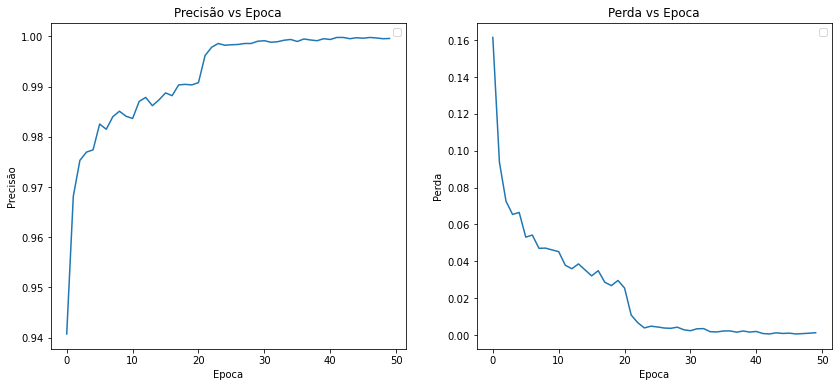

In [20]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.title('Precisão vs Epoca')
plt.xlabel('Epoca')
plt.ylabel('Precisão')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.title('Perda vs Epoca')
plt.xlabel('Epoca')
plt.ylabel('Perda')
plt.legend()
plt.show()

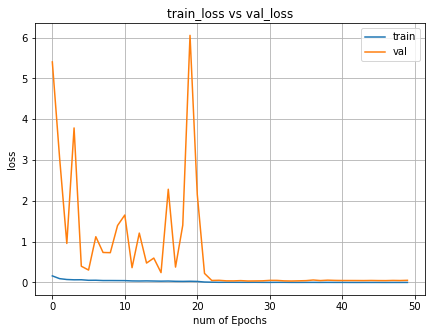

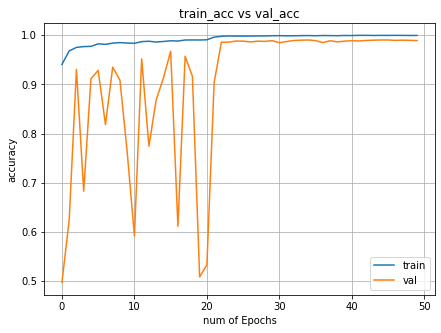

In [21]:
epochs = EPOCHS
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
#plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
#plt.style.use(['classic'])

### Result

In [22]:
model.evaluate(test_generator)

  ...
    to  
  ['...']
219/219 [==============================] - 15s 70ms/step - loss: 0.5752 - accuracy: 0.9179


[0.5751962382657341, 0.91785717]

### Salvando o modelo no drive

In [23]:
from shutil import copyfile

In [24]:
#model.save('/content/drive/MyDrive/Facens/TCC/teste_01_MobileNetV2/CelebA_Spoof_32k_MobileNetV2_30.h5')
model.save('CelebA_Spoof_32k_MobileNetV2_50.h5')

In [25]:
#copyfile('/content/transferlearning_weights_MobileNetV2.hdf5', '/content/drive/MyDrive/Facens/TCC/teste_01_MobileNetV2/transferlearning_weights_MobileNetV2.hdf5')

### Avaliando o modelo

In [26]:
y_pred = model.predict(test_generator, verbose=1)
y_pred

219/219 [==============================] - 15s 70ms/step


array([[1.0000000e+00, 2.5562150e-12],
       [1.0000000e+00, 3.5289193e-12],
       [1.0000000e+00, 5.1145394e-12],
       ...,
       [2.4453252e-08, 1.0000000e+00],
       [9.8687255e-01, 1.3127516e-02],
       [9.7458121e-07, 9.9999905e-01]], dtype=float32)

In [27]:
y_pred = y_pred.argmax(axis=1)
y_pred

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [28]:
y_test = test_generator.classes
y_test

array([0, 0, 0, ..., 1, 1, 1])

### Matriz de confusão

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [30]:
print(classification_report(y_test, y_pred, target_names=test_generator.class_indices))

              precision    recall  f1-score   support

        live       0.86      0.99      0.92      3500
       spoof       0.99      0.84      0.91      3500

    accuracy                           0.92      7000
   macro avg       0.93      0.92      0.92      7000
weighted avg       0.93      0.92      0.92      7000



In [31]:
import itertools

# Criei um grafico para mostrar a matrix de confusão
# link de referencia: https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes, normalize=False, title='Matriz de confusão', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '{:.2%}' if normalize else '{:d}'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, 
                 fmt.format(cm[i, j]),
                 horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Real')
    plt.xlabel('Predição')
    plt.tight_layout()

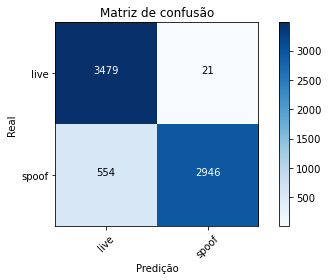

In [32]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=test_generator.class_indices, normalize=False)
plt.show()

In [33]:
cm = confusion_matrix(y_test, y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.3%}".format(acc))
print("Sensitividade: {:.3%}".format(sensitivity))
print("Especificidade: {:.3%}".format(specificity))


Acurácia: 91.786%
Sensitividade: 99.400%
Especificidade: 84.171%
